# Prophet Single (Multivariate) Models

### Models using non-standardized Data
As a note, some of my other group members standardized the data for each country before building the model. I did not do this in my model construction below. If time had allotted, we would have discussed the pros and cons of standardizing the data and eventually deciding whether or not it was necessary.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import prophet
from sklearn.preprocessing import StandardScaler
# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima.arima import auto_arima

Importing plotly failed. Interactive plots will not work.


In [2]:
# Importing imputed data

USA_train_imputed = pd.read_csv("USA_train_imputed copy.csv")
USA_test_imputed = pd.read_csv("USA_test_imputed copy.csv")
USA_train_imputed.set_index('date', inplace=True)
USA_test_imputed.set_index('date', inplace=True)

Brazil_train_imputed = pd.read_csv("Brazil_train_imputed copy.csv")
Brazil_test_imputed = pd.read_csv("Brazil_test_imputed copy.csv")
Brazil_train_imputed.set_index('date', inplace=True)
Brazil_test_imputed.set_index('date', inplace=True)

Germany_train_imputed = pd.read_csv("Germany_train_imputed copy.csv")
Germany_test_imputed = pd.read_csv("Germany_test_imputed copy.csv")
Germany_train_imputed.set_index('date', inplace=True)
Germany_test_imputed.set_index('date', inplace=True)

Nigeria_train_imputed = pd.read_csv("Nigeria_train_imputed copy.csv")
Nigeria_test_imputed = pd.read_csv("Nigeria_test_imputed copy.csv")
Nigeria_train_imputed.set_index('date', inplace=True)
Nigeria_test_imputed.set_index('date', inplace=True)

China_train_imputed = pd.read_csv("China_train_imputed copy.csv")
China_test_imputed = pd.read_csv("China_test_imputed copy.csv")
China_train_imputed.set_index('date', inplace=True)
China_test_imputed.set_index('date', inplace=True)

Australia_train_imputed = pd.read_csv("Australia_train_imputed copy.csv")
Australia_test_imputed = pd.read_csv("Australia_test_imputed copy.csv")
Australia_train_imputed.set_index('date', inplace=True)
Australia_test_imputed.set_index('date', inplace=True)

In [3]:
import warnings
warnings.filterwarnings("ignore")

# USA model (Prophet Multivariate)

In [4]:
# Checking the dataset for unique values in each column
unique_counts = USA_train_imputed.nunique()

# Identifying columns with no unique values
columns_with_no_unique_values = unique_counts[unique_counts == 1].index

# Display the columns with no unique values. We will want to drop these since 
# they are constant for all dates in the training data as it's advisable to exclude columns with non-unique values
print("Columns with no unique values:")
print(columns_with_no_unique_values)

Columns with no unique values:
Index(['iso_code', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'location', 'continent',
       'population'],
      dtype='object')


In [5]:
# Search for columns containing the word "cases." 
# We will want to drop almost all of these columns since they are collinear with the target response variable 'new_cases'
filtered_columns = USA_train_imputed.filter(like='cases')

# Display the columns that match the search criteria
print("Columns containing 'cases':")
print(filtered_columns.columns)

Columns containing 'cases':
Index(['total_cases_per_million', 'total_cases', 'new_cases_per_million',
       'new_cases', 'new_cases_smoothed_per_million', 'new_cases_smoothed',
       'new_cases_Lag_7', 'new_cases_Lag_14', 'Rolling_Mean_new_cases'],
      dtype='object')


In [6]:
# Dropping columns based on work above
USA_train_imputed = USA_train_imputed.drop(columns = columns_with_no_unique_values)
USA_train_imputed = USA_train_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
USA_train_imputed['new_cases_Lag_7'] = USA_train_imputed['new_cases_Lag_7'].fillna(0)
USA_train_imputed['new_cases_Lag_14'] = USA_train_imputed['new_cases_Lag_14'].fillna(0)
USA_train_imputed["Weekend"] = USA_train_imputed["Weekend"].astype(int)

In [7]:
# Dropping the same columns for test dataset based on conclusions of train dataset
USA_test_imputed = USA_test_imputed.drop(columns = columns_with_no_unique_values)
USA_test_imputed = USA_test_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
USA_test_imputed['new_cases_Lag_7'][0:7] = USA_test_imputed['new_cases'][-7:]
USA_test_imputed['new_cases_Lag_14'][0:14] = USA_test_imputed['new_cases'][-14:]
USA_test_imputed["Weekend"] = USA_test_imputed["Weekend"].astype(int)

In [8]:
train_target = USA_train_imputed['new_cases']
test_target = USA_test_imputed['new_cases']

In [9]:
# While developing the model, using the hyperparamter values for the model based on the Random Search results from creating the univariate Prophet model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.01, seasonality_mode ='multiplicative', growth='linear', daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.1)
for col in USA_train_imputed.columns:
    if col not in ['date', 'new_cases']:
        model.add_regressor(col)

model = model.fit(USA_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [10]:
# Make predictions for train data and looking at train RMSE
train_pred = model.predict(USA_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_rmse = np.sqrt(mean_squared_error(train_pred['yhat'], train_target))
train_rmse

22160.533270666867

In [11]:
# Make dataframes for the purposes of plotting visualization
df_train_plot = train_target.copy()
df_train_pred_plot = train_pred['yhat']

df_train_pred_plot.index = df_train_plot.index # This makes the formatting of the dates of the training and prediction data match (there were issues with train_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 22160.53")

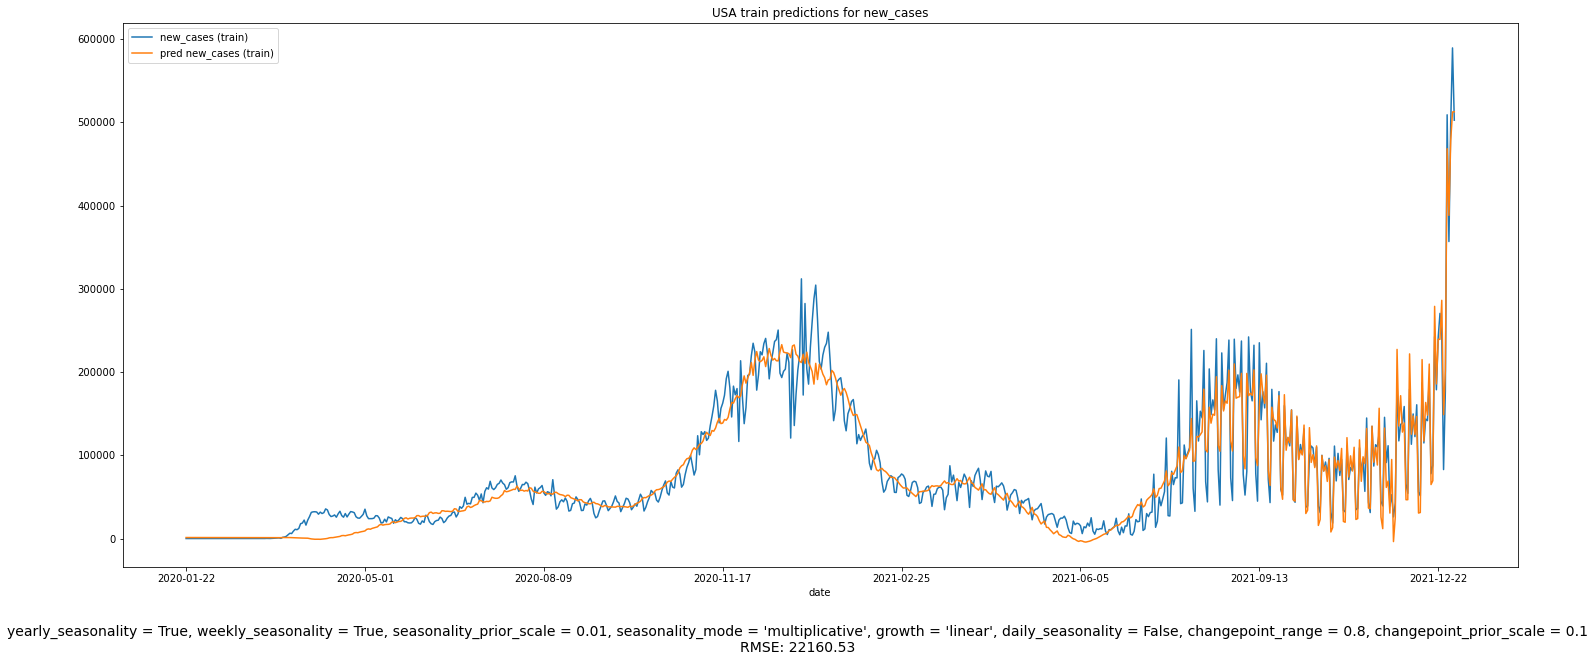

In [12]:
pd.concat([df_train_plot,df_train_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (train)', 'pred new_cases (train)'])
plt.title("USA train predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [13]:
# Make predictions for test data and looking at test RMSE
test_pred = model.predict(USA_test_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
test_rmse = np.sqrt(mean_squared_error(test_pred['yhat'], test_target))
test_rmse

478487.87453439867

In [14]:
# Make dataframes for the purposes of plotting visualization
df_test_plot = test_target.copy()
df_test_pred_plot = test_pred['yhat']

df_test_pred_plot.index = df_test_plot.index # This makes the formatting of the dates of the testting and prediction data match (there were issues with test_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 478487.87")

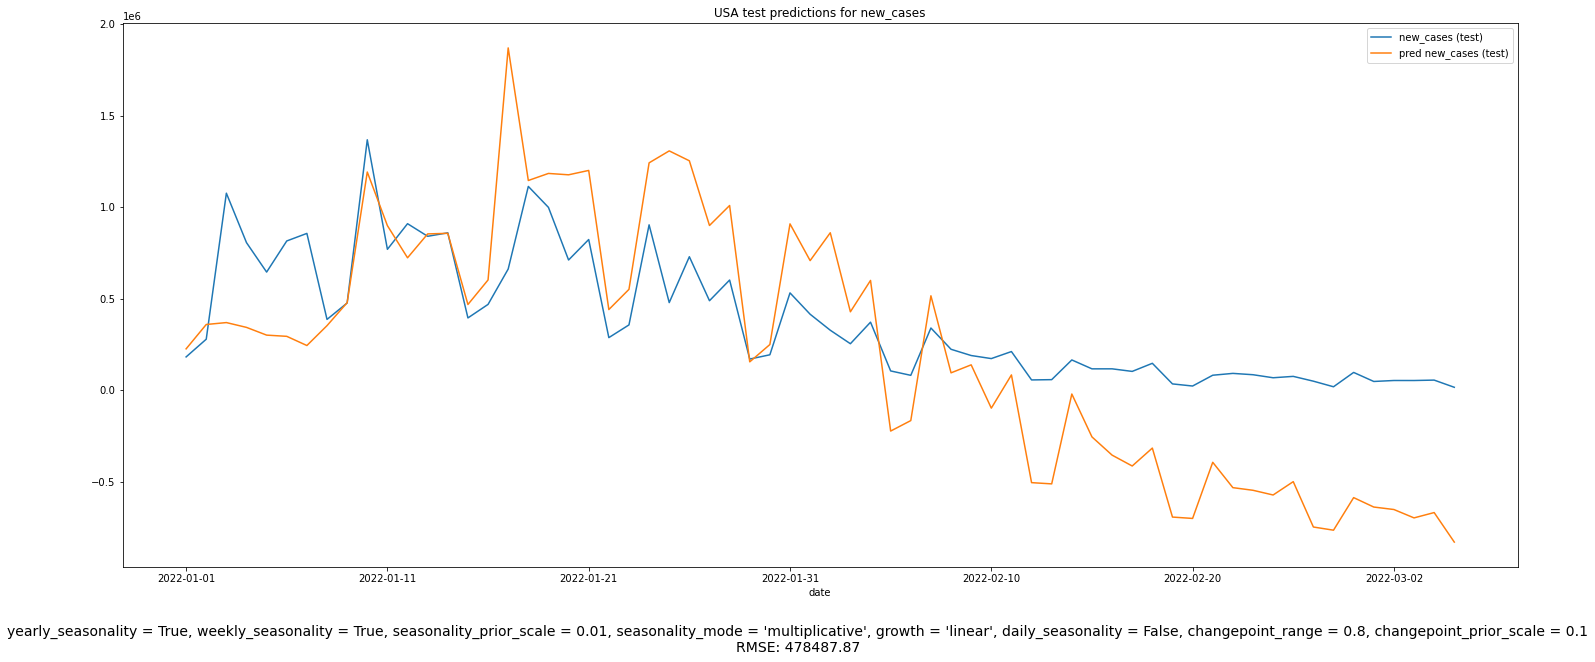

In [15]:
pd.concat([df_test_plot,df_test_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (test)', 'pred new_cases (test)'])
plt.title("USA test predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

# Brazil model (Prophet Multivariate)

In [16]:
# Checking the dataset for unique values in each column
unique_counts = Brazil_train_imputed.nunique()

# Identifying columns with no unique values
columns_with_no_unique_values = unique_counts[unique_counts == 1].index

# Display the columns with no unique values. We will want to drop these since 
# they are constant for all dates in the training data as it's advisable to exclude columns with non-unique values
print("Columns with no unique values:")
print(columns_with_no_unique_values)

Columns with no unique values:
Index(['iso_code', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population', 'location',
       'continent'],
      dtype='object')


In [17]:
# Search for columns containing the word "cases." 
# We will want to drop almost all of these columns since they are collinear with the target response variable 'new_cases'
filtered_columns = Brazil_train_imputed.filter(like='cases')

# Display the columns that match the search criteria
print("Columns containing 'cases':")
print(filtered_columns.columns)

Columns containing 'cases':
Index(['total_cases_per_million', 'total_cases', 'new_cases_per_million',
       'new_cases', 'new_cases_smoothed_per_million', 'new_cases_smoothed',
       'new_cases_Lag_7', 'new_cases_Lag_14', 'Rolling_Mean_new_cases'],
      dtype='object')


In [18]:
# Dropping columns based on work above
Brazil_train_imputed = Brazil_train_imputed.drop(columns = columns_with_no_unique_values)
Brazil_train_imputed = Brazil_train_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Brazil_train_imputed['new_cases_Lag_7'] = Brazil_train_imputed['new_cases_Lag_7'].fillna(0)
Brazil_train_imputed['new_cases_Lag_14'] = Brazil_train_imputed['new_cases_Lag_14'].fillna(0)
Brazil_train_imputed["Weekend"] = Brazil_train_imputed["Weekend"].astype(int)

In [19]:
# Dropping the same columns for test dataset based on conclusions of train dataset
Brazil_test_imputed = Brazil_test_imputed.drop(columns = columns_with_no_unique_values)
Brazil_test_imputed = Brazil_test_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Brazil_test_imputed['new_cases_Lag_7'][0:7] = Brazil_test_imputed['new_cases'][-7:]
Brazil_test_imputed['new_cases_Lag_14'][0:14] = Brazil_test_imputed['new_cases'][-14:]
Brazil_test_imputed["Weekend"] = Brazil_test_imputed["Weekend"].astype(int)

In [20]:
train_target = Brazil_train_imputed['new_cases']
test_target = Brazil_test_imputed['new_cases']

In [21]:
# While developing the model, using the hyperparamter values for the model based on the Random Search results from creating the univariate Prophet model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.01, seasonality_mode ='multiplicative', growth='linear', daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.1)
for col in Brazil_train_imputed.columns:
    if col not in ['date', 'new_cases']:
        model.add_regressor(col)

model = model.fit(Brazil_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [22]:
# Make predictions for train data and looking at train RMSE
train_pred = model.predict(Brazil_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_rmse = np.sqrt(mean_squared_error(train_pred['yhat'], train_target))
train_rmse

6279.212585740622

In [23]:
# Make dataframes for the purposes of plotting visualization
df_train_plot = train_target.copy()
df_train_pred_plot = train_pred['yhat']

df_train_pred_plot.index = df_train_plot.index # This makes the formatting of the dates of the training and prediction data match (there were issues with train_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 6279.21")

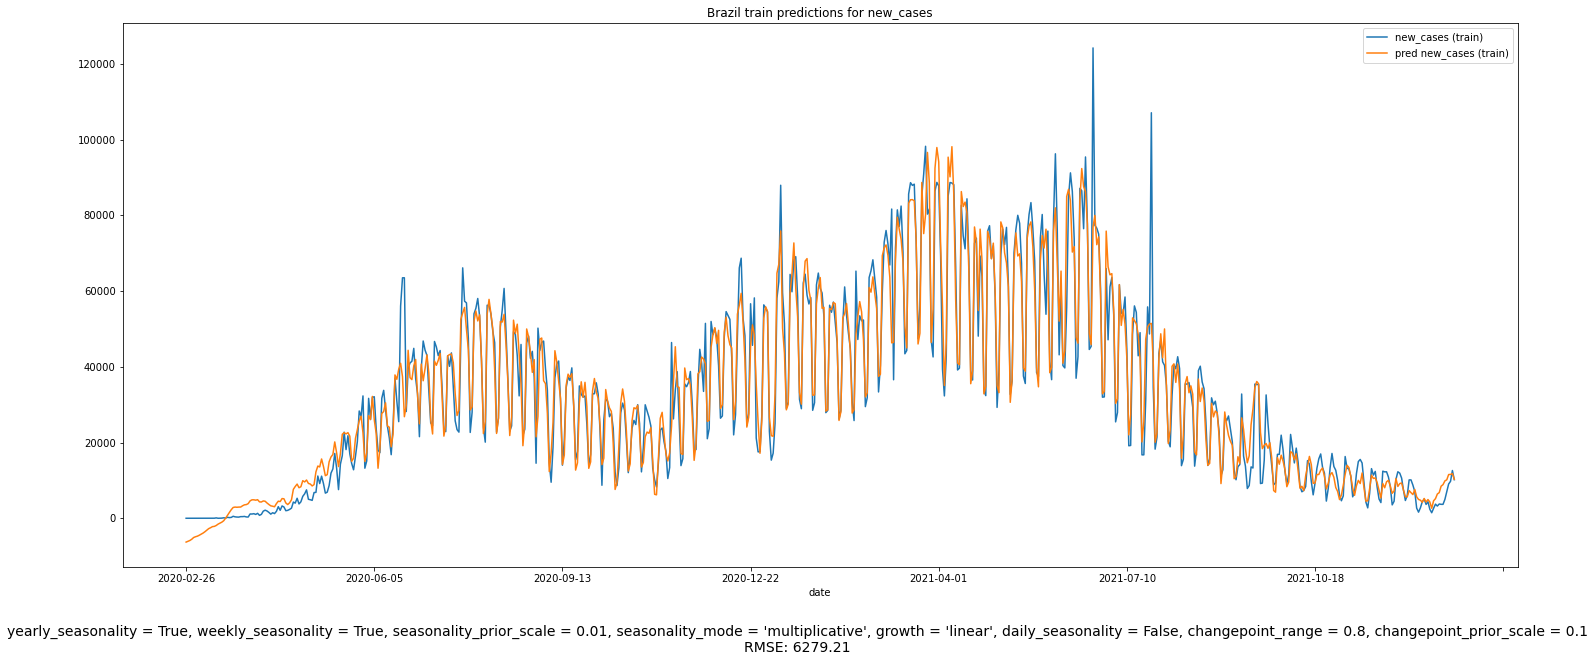

In [24]:
pd.concat([df_train_plot,df_train_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (train)', 'pred new_cases (train)'])
plt.title("Brazil train predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [25]:
# Make predictions for test data and looking at test RMSE
test_pred = model.predict(Brazil_test_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
test_rmse = np.sqrt(mean_squared_error(test_pred['yhat'], test_target))
test_rmse

120818.70266300374

In [26]:
# Make dataframes for the purposes of plotting visualization
df_test_plot = test_target.copy()
df_test_pred_plot = test_pred['yhat']

df_test_pred_plot.index = df_test_plot.index # This makes the formatting of the dates of the testting and prediction data match (there were issues with test_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 120818.70")

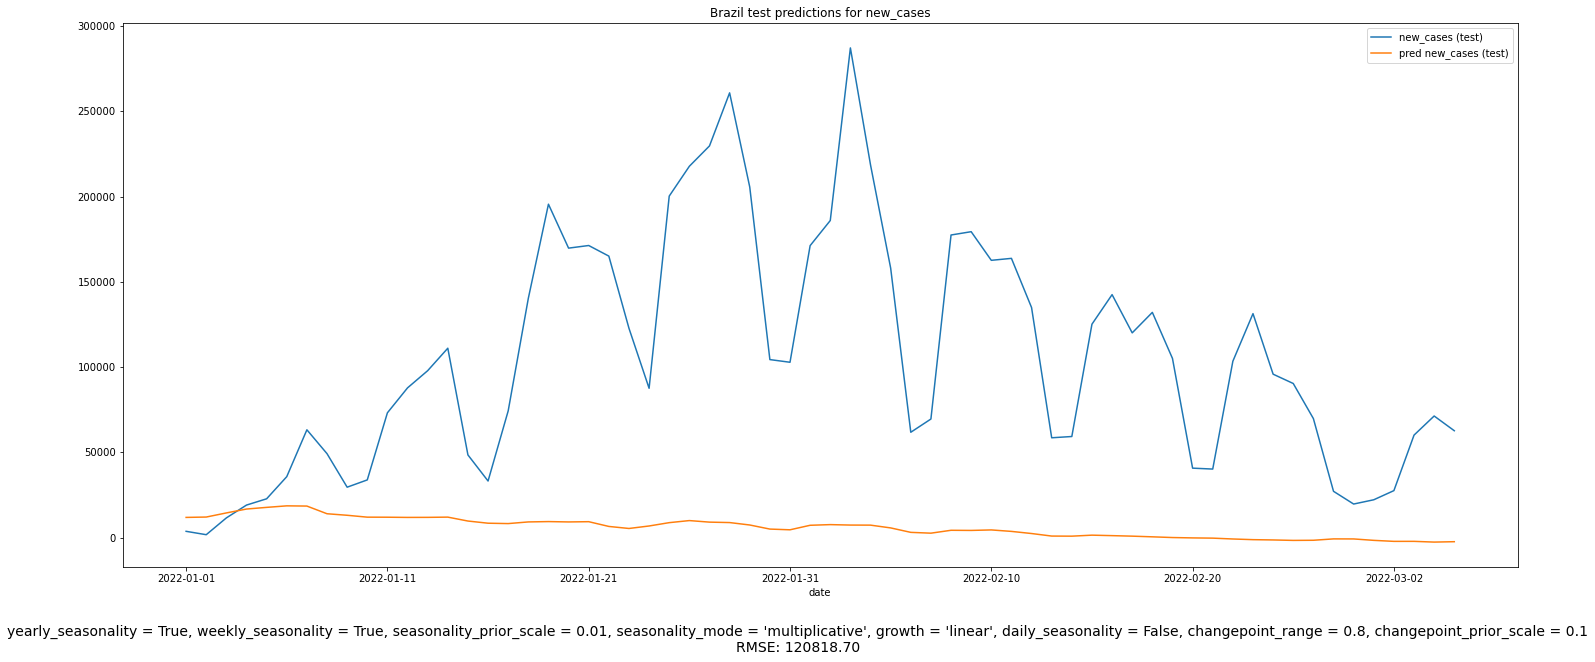

In [27]:
pd.concat([df_test_plot,df_test_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (test)', 'pred new_cases (test)'])
plt.title("Brazil test predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

# Germany model (Prophet Multivariate)

In [28]:
# Checking the dataset for unique values in each column
unique_counts = Germany_train_imputed.nunique()

# Identifying columns with no unique values
columns_with_no_unique_values = unique_counts[unique_counts == 1].index

# Display the columns with no unique values. We will want to drop these since 
# they are constant for all dates in the training data as it's advisable to exclude columns with non-unique values
print("Columns with no unique values:")
print(columns_with_no_unique_values)

Columns with no unique values:
Index(['iso_code', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'hospital_beds_per_thousand', 'population', 'life_expectancy',
       'continent', 'location', 'human_development_index'],
      dtype='object')


In [29]:
# Search for columns containing the word "cases." 
# We will want to drop almost all of these columns since they are collinear with the target response variable 'new_cases'
filtered_columns = Germany_train_imputed.filter(like='cases')

# Display the columns that match the search criteria
print("Columns containing 'cases':")
print(filtered_columns.columns)

Columns containing 'cases':
Index(['total_cases_per_million', 'total_cases', 'new_cases_per_million',
       'new_cases', 'new_cases_smoothed', 'new_cases_smoothed_per_million',
       'new_cases_Lag_7', 'new_cases_Lag_14', 'Rolling_Mean_new_cases'],
      dtype='object')


In [30]:
# Dropping columns based on work above
Germany_train_imputed = Germany_train_imputed.drop(columns = columns_with_no_unique_values)
Germany_train_imputed = Germany_train_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Germany_train_imputed['new_cases_Lag_7'] = Germany_train_imputed['new_cases_Lag_7'].fillna(0)
Germany_train_imputed['new_cases_Lag_14'] = Germany_train_imputed['new_cases_Lag_14'].fillna(0)
Germany_train_imputed["Weekend"] = Germany_train_imputed["Weekend"].astype(int)

In [31]:
# Dropping the same columns for test dataset based on conclusions of train dataset
Germany_test_imputed = Germany_test_imputed.drop(columns = columns_with_no_unique_values)
Germany_test_imputed = Germany_test_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Germany_test_imputed['new_cases_Lag_7'][0:7] = Germany_test_imputed['new_cases'][-7:]
Germany_test_imputed['new_cases_Lag_14'][0:14] = Germany_test_imputed['new_cases'][-14:]
Germany_test_imputed["Weekend"] = Germany_test_imputed["Weekend"].astype(int)

In [32]:
train_target = Germany_train_imputed['new_cases']
test_target = Germany_test_imputed['new_cases']

In [33]:
# While developing the model, using the hyperparamter values for the model based on the Random Search results from creating the univariate Prophet model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.01, seasonality_mode ='multiplicative', growth='linear', daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.1)
for col in Germany_train_imputed.columns:
    if col not in ['date', 'new_cases']:
        model.add_regressor(col)

model = model.fit(Germany_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [34]:
# Make predictions for train data and looking at train RMSE
train_pred = model.predict(Germany_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_rmse = np.sqrt(mean_squared_error(train_pred['yhat'], train_target))
train_rmse

4441.84788156138

In [35]:
# Make dataframes for the purposes of plotting visualization
df_train_plot = train_target.copy()
df_train_pred_plot = train_pred['yhat']

df_train_pred_plot.index = df_train_plot.index # This makes the formatting of the dates of the training and prediction data match (there were issues with train_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 4441.85")

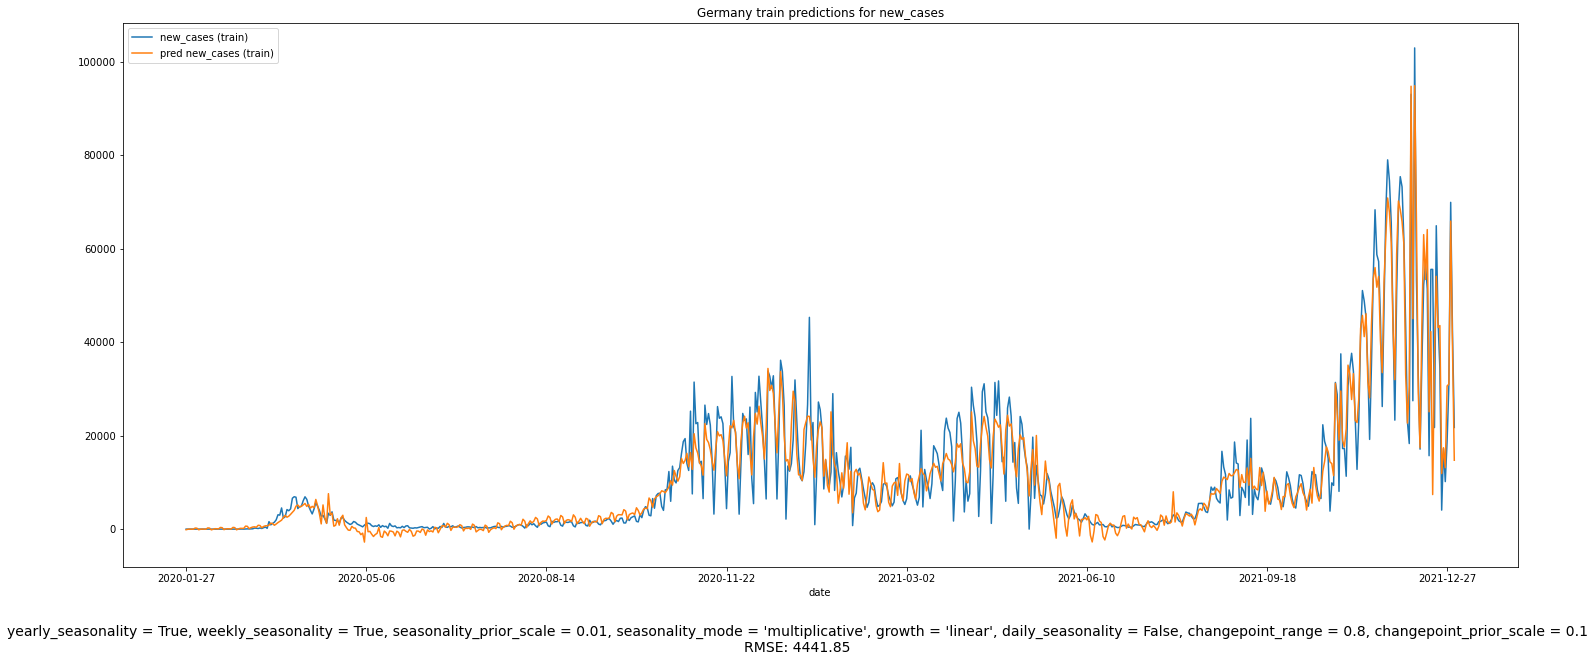

In [36]:
pd.concat([df_train_plot,df_train_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (train)', 'pred new_cases (train)'])
plt.title("Germany train predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [37]:
# Make predictions for test data and looking at test RMSE
test_pred = model.predict(Germany_test_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
test_rmse = np.sqrt(mean_squared_error(test_pred['yhat'], test_target))
test_rmse

68766.5280722594

In [38]:
# Make dataframes for the purposes of plotting visualization
df_test_plot = test_target.copy()
df_test_pred_plot = test_pred['yhat']

df_test_pred_plot.index = df_test_plot.index # This makes the formatting of the dates of the testting and prediction data match (there were issues with test_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 68766.53")

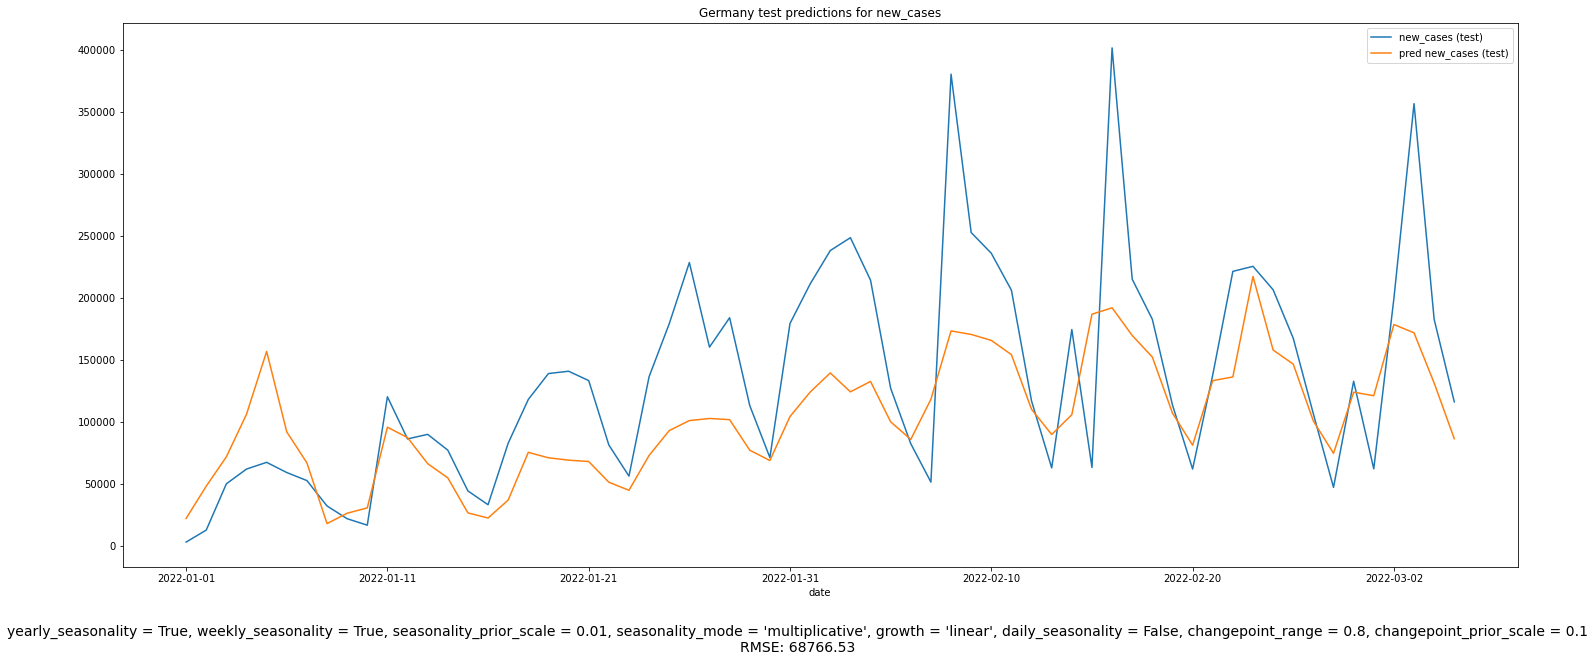

In [39]:
pd.concat([df_test_plot,df_test_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (test)', 'pred new_cases (test)'])
plt.title("Germany test predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

# China model (Prophet Multivariate)

In [40]:
# Checking the dataset for unique values in each column
unique_counts = China_train_imputed.nunique()

# Identifying columns with no unique values
columns_with_no_unique_values = unique_counts[unique_counts == 1].index

# Display the columns with no unique values. We will want to drop these since 
# they are constant for all dates in the training data as it's advisable to exclude columns with non-unique values
print("Columns with no unique values:")
print(columns_with_no_unique_values)

Columns with no unique values:
Index(['iso_code', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'life_expectancy', 'human_development_index',
       'hospital_beds_per_thousand', 'continent', 'location'],
      dtype='object')


In [41]:
# Search for columns containing the word "cases." 
# We will want to drop almost all of these columns since they are collinear with the target response variable 'new_cases'
filtered_columns = China_train_imputed.filter(like='cases')

# Display the columns that match the search criteria
print("Columns containing 'cases':")
print(filtered_columns.columns)

Columns containing 'cases':
Index(['total_cases_per_million', 'total_cases', 'new_cases_per_million',
       'new_cases', 'new_cases_smoothed', 'new_cases_smoothed_per_million',
       'new_cases_Lag_7', 'new_cases_Lag_14', 'Rolling_Mean_new_cases'],
      dtype='object')


In [42]:
# Dropping columns based on work above
China_train_imputed = China_train_imputed.drop(columns = columns_with_no_unique_values)
China_train_imputed = China_train_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
China_train_imputed['new_cases_Lag_7'] = China_train_imputed['new_cases_Lag_7'].fillna(0)
China_train_imputed['new_cases_Lag_14'] = China_train_imputed['new_cases_Lag_14'].fillna(0)
China_train_imputed["Weekend"] = China_train_imputed["Weekend"].astype(int)

In [43]:
# Dropping the same columns for test dataset based on conclusions of train dataset
China_test_imputed = China_test_imputed.drop(columns = columns_with_no_unique_values)
China_test_imputed = China_test_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
China_test_imputed['new_cases_Lag_7'][0:7] = China_test_imputed['new_cases'][-7:]
China_test_imputed['new_cases_Lag_14'][0:14] = China_test_imputed['new_cases'][-14:]
China_test_imputed["Weekend"] = China_test_imputed["Weekend"].astype(int)

In [44]:
train_target = China_train_imputed['new_cases']
test_target = China_test_imputed['new_cases']

In [45]:
# While developing the model, using the hyperparamter values for the model based on the Random Search results from creating the univariate Prophet model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.01, seasonality_mode ='multiplicative', growth='linear', daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.1)
for col in China_train_imputed.columns:
    if col not in ['date', 'new_cases']:
        model.add_regressor(col)

model = model.fit(China_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [46]:
# Make predictions for train data and looking at train RMSE
train_pred = model.predict(China_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_rmse = np.sqrt(mean_squared_error(train_pred['yhat'], train_target))
train_rmse

205.0150794011758

In [47]:
# Make dataframes for the purposes of plotting visualization
df_train_plot = train_target.copy()
df_train_pred_plot = train_pred['yhat']

df_train_pred_plot.index = df_train_plot.index # This makes the formatting of the dates of the training and prediction data match (there were issues with train_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 205.02")

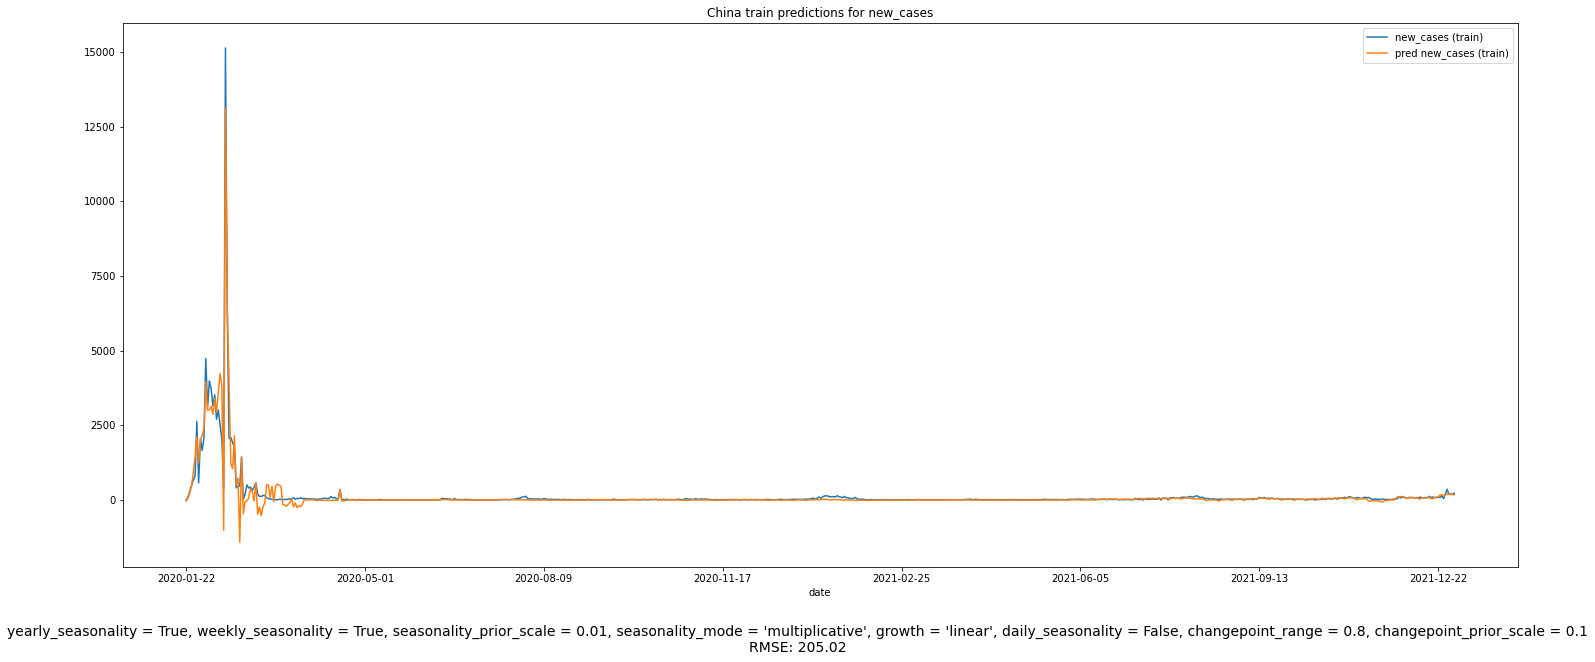

In [48]:
pd.concat([df_train_plot,df_train_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (train)', 'pred new_cases (train)'])
plt.title("China train predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [49]:
# Make predictions for test data and looking at test RMSE
test_pred = model.predict(China_test_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
test_rmse = np.sqrt(mean_squared_error(test_pred['yhat'], test_target))
test_rmse

75.05436052920986

In [50]:
# Make dataframes for the purposes of plotting visualization
df_test_plot = test_target.copy()
df_test_pred_plot = test_pred['yhat']

df_test_pred_plot.index = df_test_plot.index # This makes the formatting of the dates of the testting and prediction data match (there were issues with test_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 75.05")

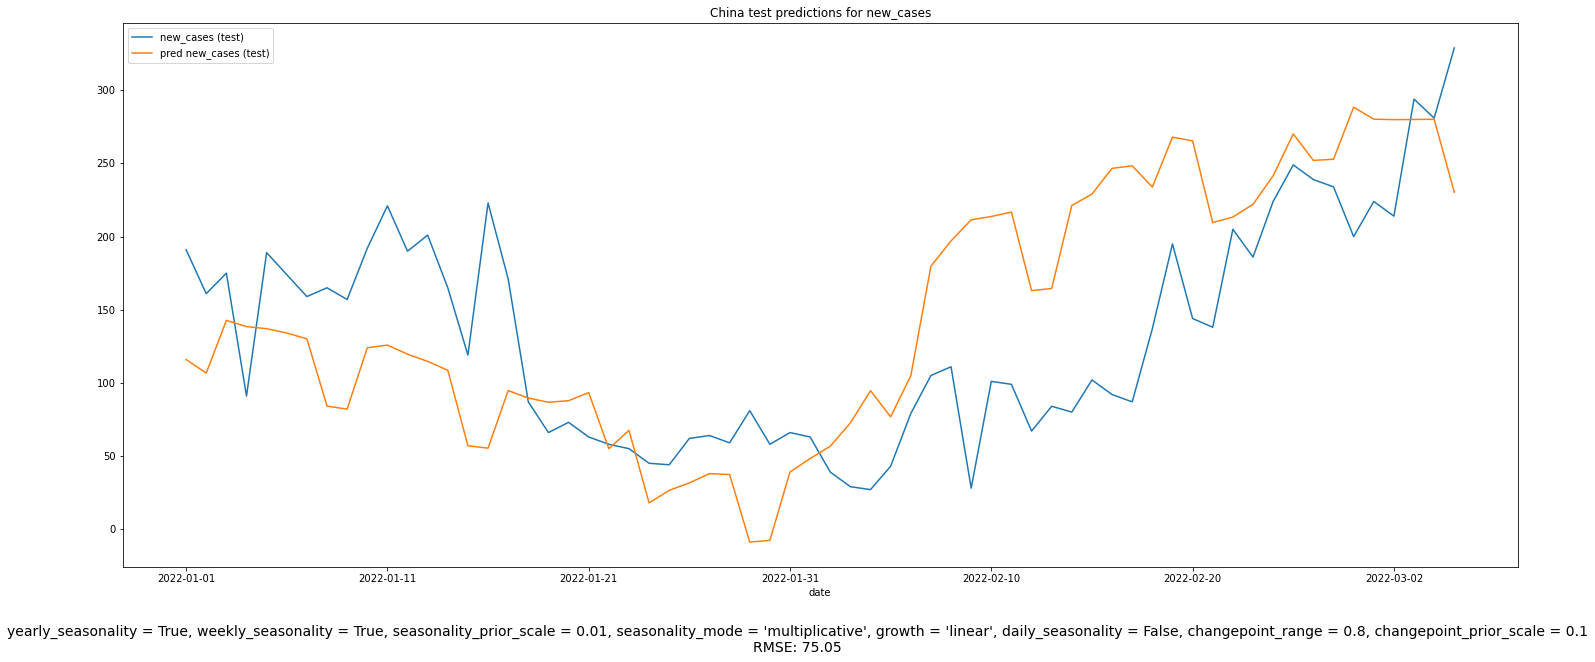

In [51]:
pd.concat([df_test_plot,df_test_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (test)', 'pred new_cases (test)'])
plt.title("China test predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

# Nigeria model (Prophet Multivariate)

In [52]:
# Checking the dataset for unique values in each column
unique_counts = Nigeria_train_imputed.nunique()

# Identifying columns with no unique values
columns_with_no_unique_values = unique_counts[unique_counts == 1].index

# Display the columns with no unique values. We will want to drop these since 
# they are constant for all dates in the training data as it's advisable to exclude columns with non-unique values
print("Columns with no unique values:")
print(columns_with_no_unique_values)

Columns with no unique values:
Index(['iso_code', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'handwashing_facilities', 'life_expectancy', 'human_development_index',
       'population', 'location', 'continent'],
      dtype='object')


In [53]:
# Search for columns containing the word "cases." 
# We will want to drop almost all of these columns since they are collinear with the target response variable 'new_cases'
filtered_columns = Nigeria_train_imputed.filter(like='cases')

# Display the columns that match the search criteria
print("Columns containing 'cases':")
print(filtered_columns.columns)

Columns containing 'cases':
Index(['new_cases_per_million', 'total_cases_per_million', 'new_cases',
       'total_cases', 'new_cases_smoothed_per_million', 'new_cases_smoothed',
       'new_cases_Lag_7', 'new_cases_Lag_14', 'Rolling_Mean_new_cases'],
      dtype='object')


In [54]:
# Dropping columns based on work above
Nigeria_train_imputed = Nigeria_train_imputed.drop(columns = columns_with_no_unique_values)
Nigeria_train_imputed = Nigeria_train_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Nigeria_train_imputed['new_cases_Lag_7'] = Nigeria_train_imputed['new_cases_Lag_7'].fillna(0)
Nigeria_train_imputed['new_cases_Lag_14'] = Nigeria_train_imputed['new_cases_Lag_14'].fillna(0)
Nigeria_train_imputed["Weekend"] = Nigeria_train_imputed["Weekend"].astype(int)

In [55]:
# Dropping the same columns for test dataset based on conclusions of train dataset
Nigeria_test_imputed = Nigeria_test_imputed.drop(columns = columns_with_no_unique_values)
Nigeria_test_imputed = Nigeria_test_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Nigeria_test_imputed['new_cases_Lag_7'][0:7] = Nigeria_test_imputed['new_cases'][-7:]
Nigeria_test_imputed['new_cases_Lag_14'][0:14] = Nigeria_test_imputed['new_cases'][-14:]
Nigeria_test_imputed["Weekend"] = Nigeria_test_imputed["Weekend"].astype(int)

In [56]:
train_target = Nigeria_train_imputed['new_cases']
test_target = Nigeria_test_imputed['new_cases']

In [57]:
# While developing the model, using the hyperparamter values for the model based on the Random Search results from creating the univariate Prophet model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.01, seasonality_mode ='multiplicative', growth='linear', daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.1)
for col in Nigeria_train_imputed.columns:
    if col not in ['date', 'new_cases']:
        model.add_regressor(col)

model = model.fit(Nigeria_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [58]:
# Make predictions for train data and looking at train RMSE
train_pred = model.predict(Nigeria_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_rmse = np.sqrt(mean_squared_error(train_pred['yhat'], train_target))
train_rmse

257.96676629545595

In [59]:
# Make dataframes for the purposes of plotting visualization
df_train_plot = train_target.copy()
df_train_pred_plot = train_pred['yhat']

df_train_pred_plot.index = df_train_plot.index # This makes the formatting of the dates of the training and prediction data match (there were issues with train_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 257.97")

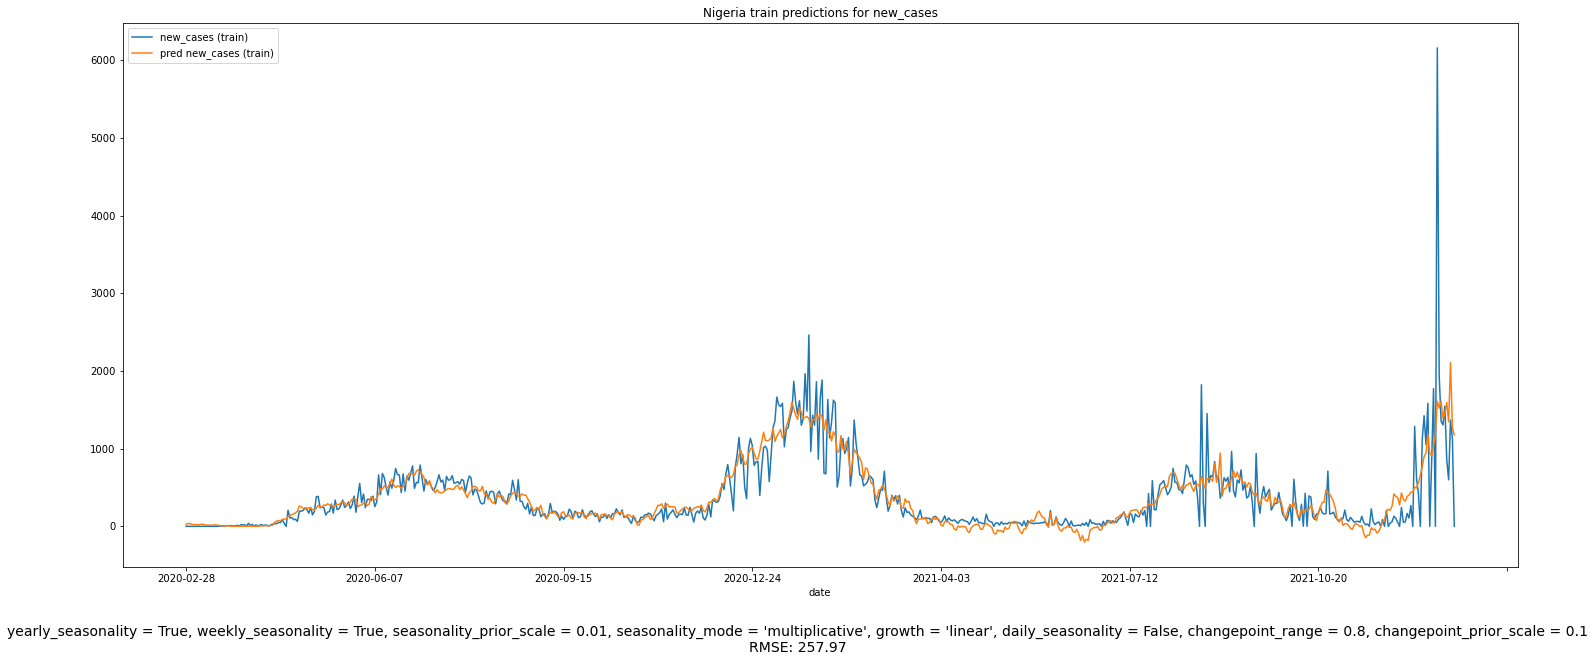

In [60]:
pd.concat([df_train_plot,df_train_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (train)', 'pred new_cases (train)'])
plt.title("Nigeria train predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [61]:
# Make predictions for test data and looking at test RMSE
test_pred = model.predict(Nigeria_test_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
test_rmse = np.sqrt(mean_squared_error(test_pred['yhat'], test_target))
test_rmse

282.223613033875

In [62]:
# Make dataframes for the purposes of plotting visualization
df_test_plot = test_target.copy()
df_test_pred_plot = test_pred['yhat']

df_test_pred_plot.index = df_test_plot.index # This makes the formatting of the dates of the testting and prediction data match (there were issues with test_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 282.22")

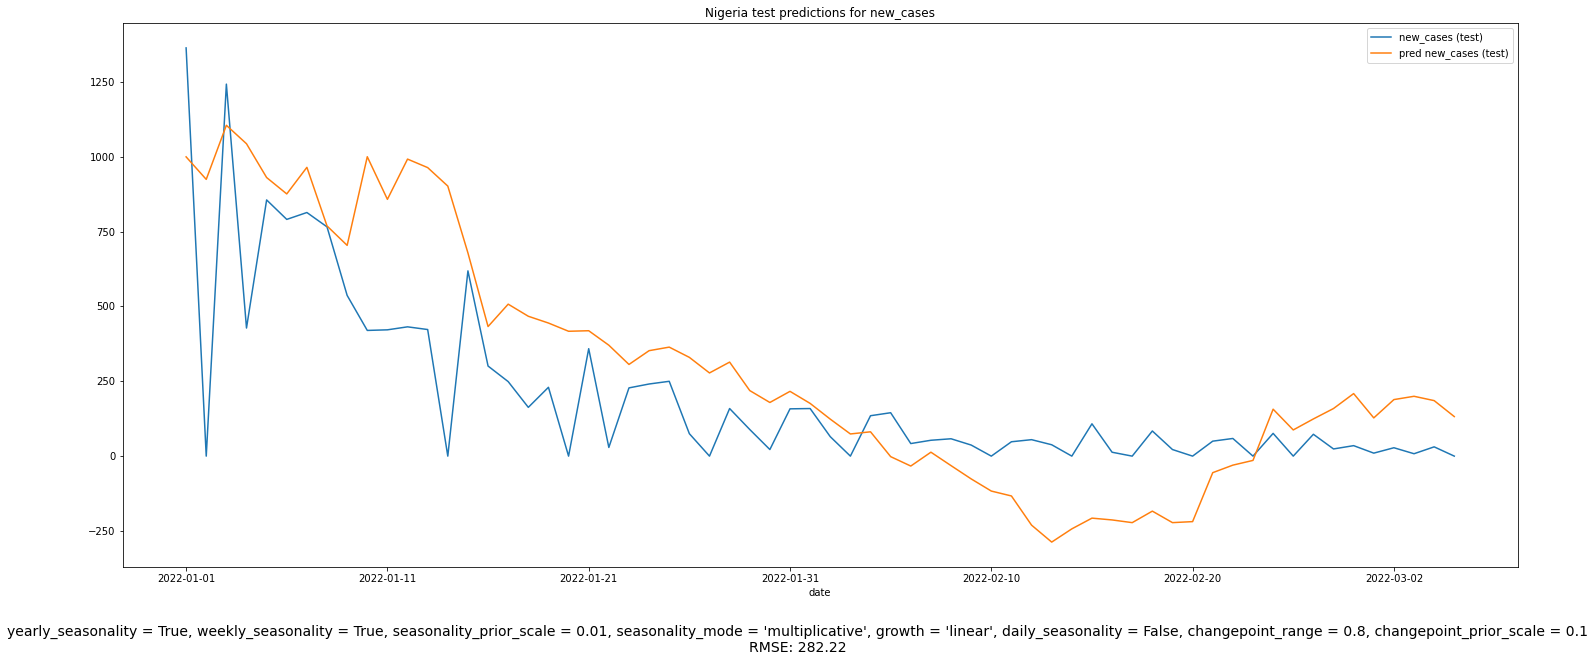

In [63]:
pd.concat([df_test_plot,df_test_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (test)', 'pred new_cases (test)'])
plt.title("Nigeria test predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

# Australia model (Prophet Multivariate)

In [64]:
# Checking the dataset for unique values in each column
unique_counts = Australia_train_imputed.nunique()

# Identifying columns with no unique values
columns_with_no_unique_values = unique_counts[unique_counts == 1].index

# Display the columns with no unique values. We will want to drop these since 
# they are constant for all dates in the training data as it's advisable to exclude columns with non-unique values
print("Columns with no unique values:")
print(columns_with_no_unique_values)

Columns with no unique values:
Index(['iso_code', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'location', 'continent',
       'population'],
      dtype='object')


In [65]:
# Search for columns containing the word "cases." 
# We will want to drop almost all of these columns since they are collinear with the target response variable 'new_cases'
filtered_columns = Australia_train_imputed.filter(like='cases')

# Display the columns that match the search criteria
print("Columns containing 'cases':")
print(filtered_columns.columns)

Columns containing 'cases':
Index(['new_cases_per_million', 'total_cases_per_million', 'new_cases',
       'total_cases', 'new_cases_smoothed_per_million', 'new_cases_smoothed',
       'new_cases_Lag_7', 'new_cases_Lag_14', 'Rolling_Mean_new_cases'],
      dtype='object')


In [66]:
# Dropping columns based on work above
Australia_train_imputed = Australia_train_imputed.drop(columns = columns_with_no_unique_values)
Australia_train_imputed = Australia_train_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Australia_train_imputed['new_cases_Lag_7'] = Australia_train_imputed['new_cases_Lag_7'].fillna(0)
Australia_train_imputed['new_cases_Lag_14'] = Australia_train_imputed['new_cases_Lag_14'].fillna(0)
Australia_train_imputed["Weekend"] = Australia_train_imputed["Weekend"].astype(int)

In [67]:
# Dropping the same columns for test dataset based on conclusions of train dataset
Australia_test_imputed = Australia_test_imputed.drop(columns = columns_with_no_unique_values)
Australia_test_imputed = Australia_test_imputed.drop(columns = ['total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Australia_test_imputed['new_cases_Lag_7'][0:7] = Australia_test_imputed['new_cases'][-7:]
Australia_test_imputed['new_cases_Lag_14'][0:14] = Australia_test_imputed['new_cases'][-14:]
Australia_test_imputed["Weekend"] = Australia_test_imputed["Weekend"].astype(int)

In [68]:
train_target = Australia_train_imputed['new_cases']
test_target = Australia_test_imputed['new_cases']

In [69]:
# While developing the model, using the hyperparamter values for the model based on the Random Search results from creating the univariate Prophet model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.01, seasonality_mode ='multiplicative', growth='linear', daily_seasonality=False, changepoint_range=0.8, changepoint_prior_scale=0.1)
for col in Australia_train_imputed.columns:
    if col not in ['date', 'new_cases']:
        model.add_regressor(col)

model = model.fit(Australia_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'}))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [70]:
# Make predictions for train data and looking at train RMSE
train_pred = model.predict(Australia_train_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
train_rmse = np.sqrt(mean_squared_error(train_pred['yhat'], train_target))
train_rmse

282.76111564336503

In [71]:
# Make dataframes for the purposes of plotting visualization
df_train_plot = train_target.copy()
df_train_pred_plot = train_pred['yhat']

df_train_pred_plot.index = df_train_plot.index # This makes the formatting of the dates of the training and prediction data match (there were issues with train_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 282.76")

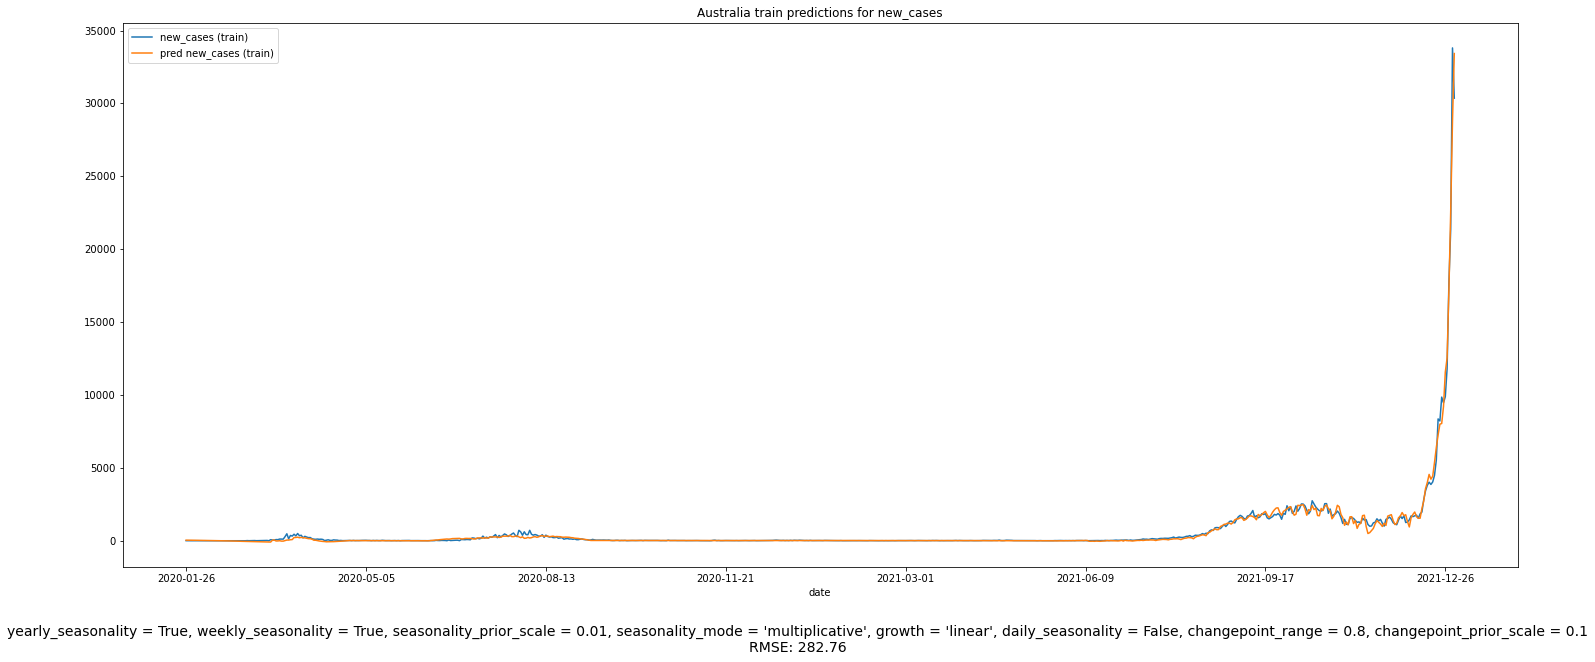

In [72]:
pd.concat([df_train_plot,df_train_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (train)', 'pred new_cases (train)'])
plt.title("Australia train predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [73]:
# Make predictions for test data and looking at test RMSE
test_pred = model.predict(Australia_test_imputed.reset_index().rename(columns={'date':'ds', 'new_cases':'y'})).set_index('ds')
test_rmse = np.sqrt(mean_squared_error(test_pred['yhat'], test_target))
test_rmse

187200.13077140908

In [74]:
# Make dataframes for the purposes of plotting visualization
df_test_plot = test_target.copy()
df_test_pred_plot = test_pred['yhat']

df_test_pred_plot.index = df_test_plot.index # This makes the formatting of the dates of the testting and prediction data match (there were issues with test_pred having additional timestamps, which affected the visualization)

Text(0.5, 0.01, "yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1\nRMSE: 187200.13")

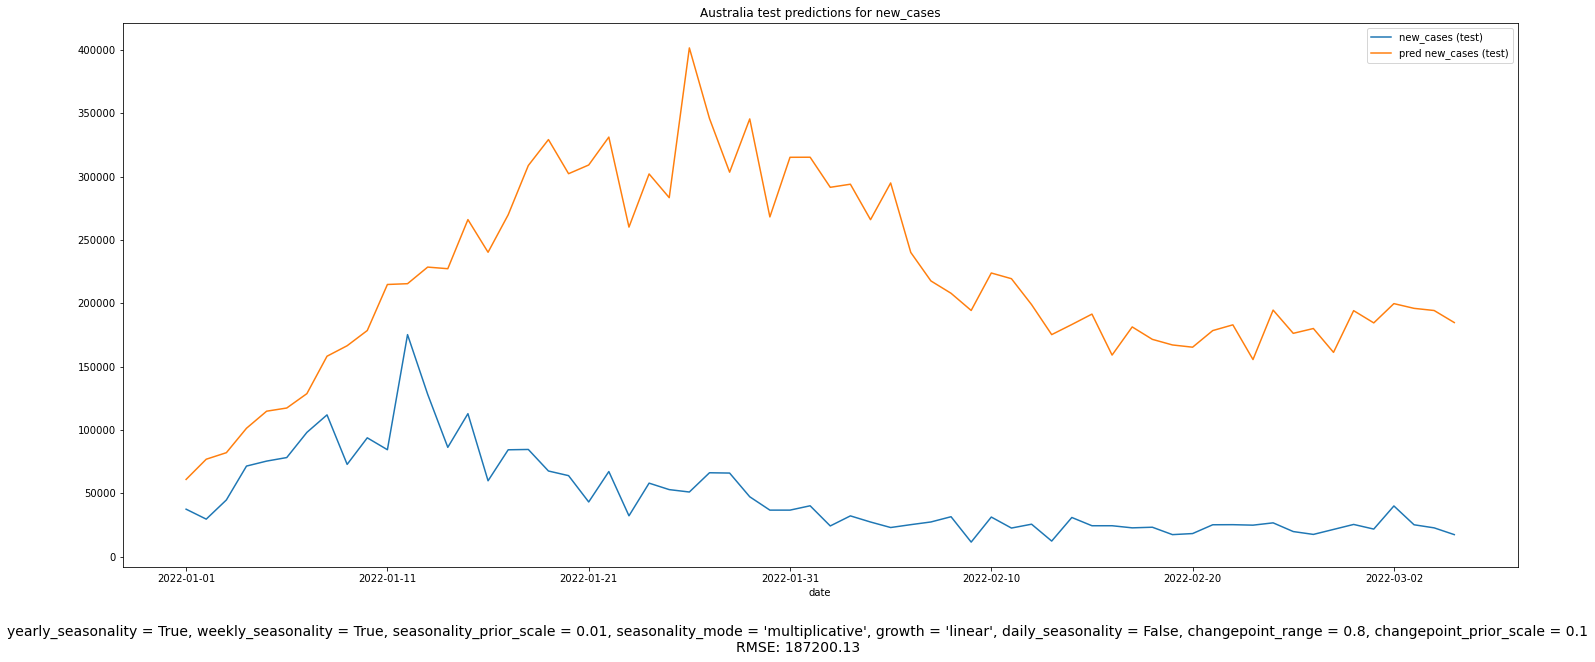

In [75]:
pd.concat([df_test_plot,df_test_pred_plot], axis=1).plot(figsize=(25,10)) 
# Original concatting was producing data that was not properly layed on top of each other
plt.legend(['new_cases (test)', 'pred new_cases (test)'])
plt.title("Australia test predictions for new_cases")
txt="yearly_seasonality = True, weekly_seasonality = True, seasonality_prior_scale = 0.01, seasonality_mode = 'multiplicative', growth = 'linear', daily_seasonality = False, changepoint_range = 0.8, changepoint_prior_scale = 0.1"
txt += f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)